Data fetched successfully!


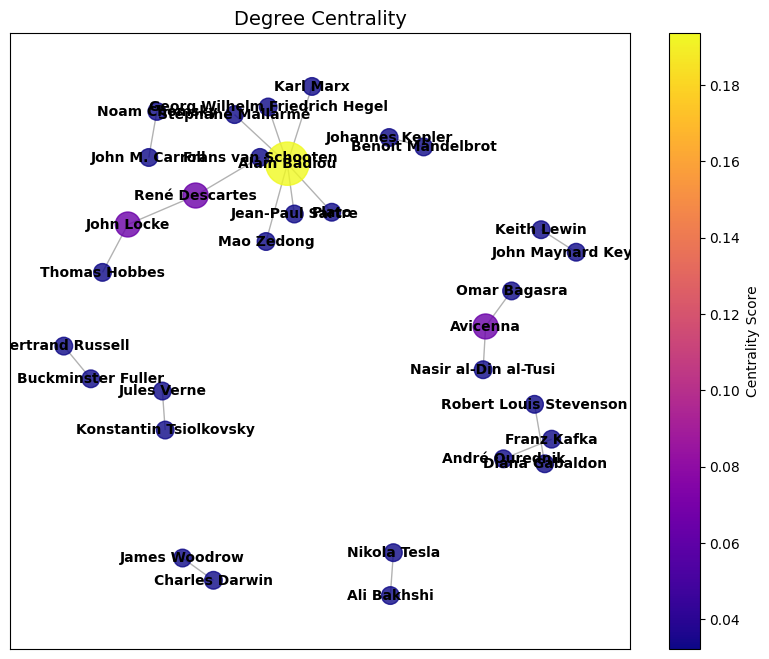

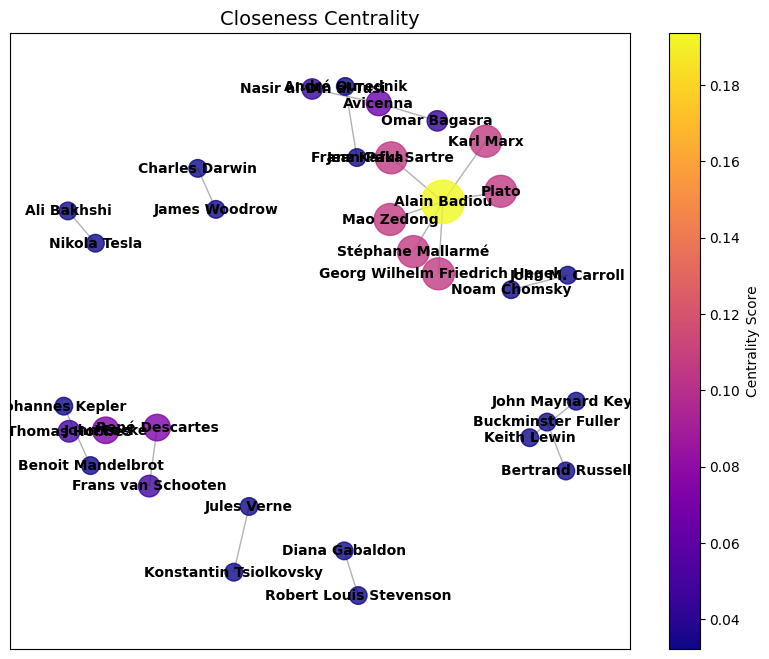

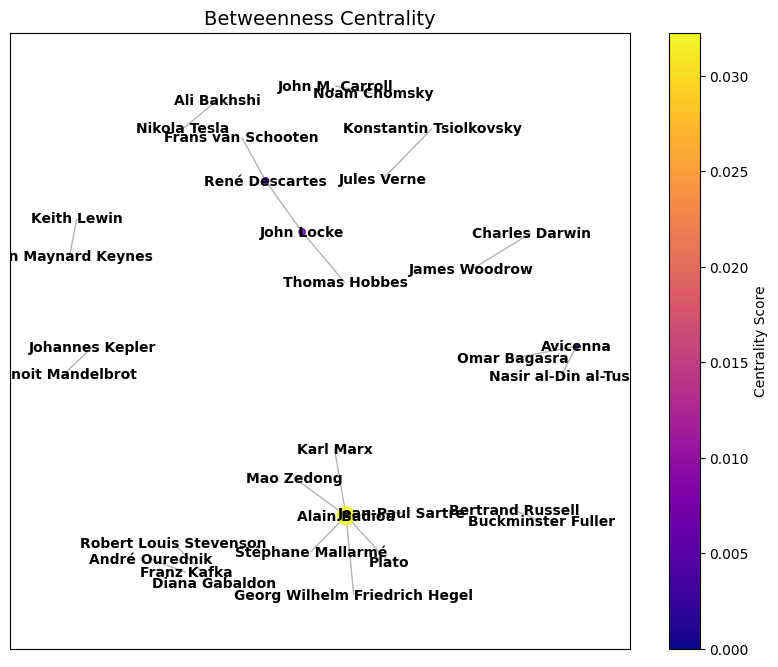

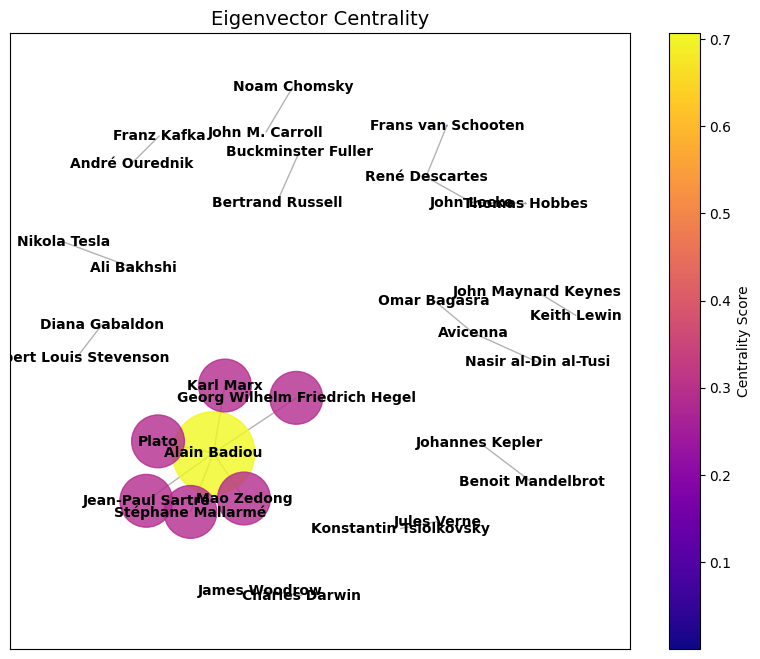

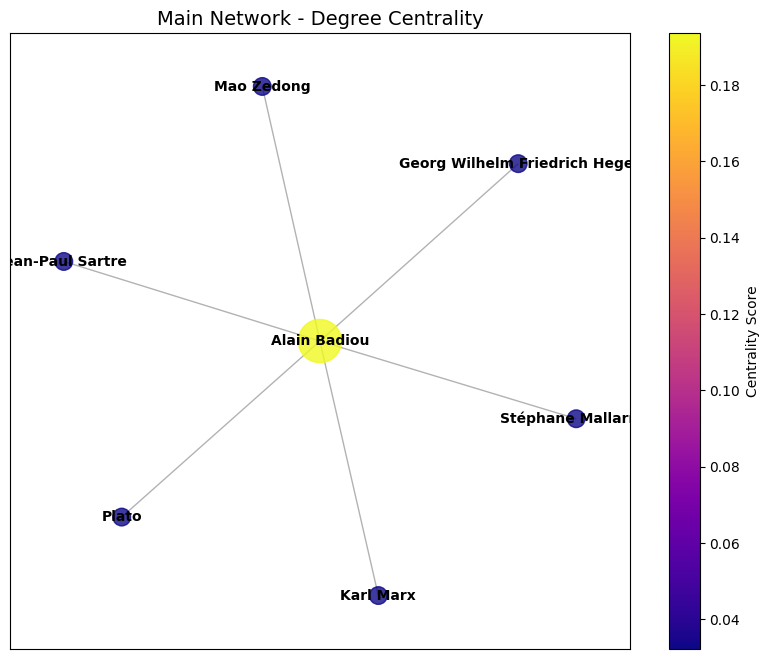

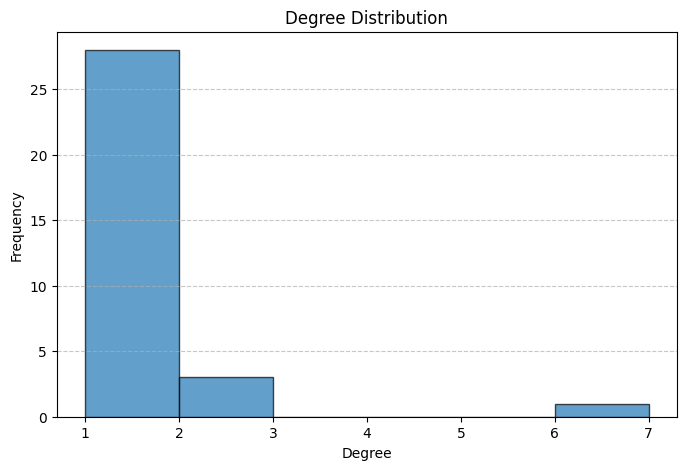

In [1]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Fetch data from Wikidata API
query = """
SELECT ?scientist1 ?scientist1Label ?scientist2 ?scientist2Label WHERE {
  ?scientist1 wdt:P31 wd:Q5;  # Instance of human
              wdt:P106 wd:Q901;  # Occupation: Scientist
              wdt:P737 ?scientist2.  # Influenced by
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
} LIMIT 20
"""

url = "https://query.wikidata.org/sparql"
headers = {"User-Agent": "Mozilla/5.0"}
params = {"format": "json", "query": query}

try:
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    data = response.json()
    print("Data fetched successfully!")
except Exception as e:
    print(f"Error fetching data: {e}")
    exit()

# Build Graph
G = nx.Graph()
for result in data["results"]["bindings"]:
    scientist1 = result["scientist1Label"]["value"]
    scientist2 = result["scientist2Label"]["value"]
    G.add_edge(scientist1, scientist2)

# Compute Centrality Measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Function to visualize centrality measures
def visualize_centrality(G, centrality, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.4)  # Improved spacing

    node_size = [v * 5000 for v in centrality.values()]  # Scale node sizes
    labels = {node: node for node in G.nodes()}  # Labels for nodes

    # Create color mapping
    cmap = cm.plasma
    vmin, vmax = min(centrality.values()), max(centrality.values())

    sm = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # Fix for colorbar issue

    nx.draw_networkx_nodes(
        G, pos, node_color=list(centrality.values()), cmap=cmap,
        node_size=node_size, alpha=0.8, vmin=vmin, vmax=vmax, ax=ax
    )
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)  # Transparent edges
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight="bold", ax=ax)

    plt.title(title, fontsize=14)
    cbar = plt.colorbar(sm, ax=ax)  # Fixed colorbar issue
    cbar.set_label("Centrality Score")
    plt.show()

# Visualize Centrality Measures
visualize_centrality(G, degree_centrality, "Degree Centrality")
visualize_centrality(G, closeness_centrality, "Closeness Centrality")
visualize_centrality(G, betweenness_centrality, "Betweenness Centrality")
visualize_centrality(G, eigenvector_centrality, "Eigenvector Centrality")

# Extract Main Network (Largest Connected Component)
largest_component = max(nx.connected_components(G), key=len)
main_network = G.subgraph(largest_component)

# Filter the centrality measures for nodes in the main network
filtered_degree_centrality = {node: degree_centrality[node] for node in main_network.nodes()}

# Visualize Main Network with updated centrality measures
visualize_centrality(main_network, filtered_degree_centrality, "Main Network - Degree Centrality")

# Degree Distribution Plot
degree_sequence = [d for _, d in G.degree()]
plt.figure(figsize=(8, 5))
plt.hist(degree_sequence, bins=range(1, max(degree_sequence) + 2), edgecolor="black", alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
